In [1]:
import torch

import torch as t
from torch import Tensor
import einops

from transformer_lens import HookedTransformer

from EAP_wrapper import EAP

from jaxtyping import Float

device = t.device('cuda') if t.cuda.is_available() else t.device('cpu')
print(f'Device: {device}')

Device: cuda


# Model Setup

In [2]:
model = HookedTransformer.from_pretrained(
    'gpt2-small',
    center_writing_weights=False,
    center_unembed=False,
    fold_ln=False,
    device=device,
)
model.set_use_hook_mlp_in(True)
model.set_use_split_qkv_input(True)
model.set_use_attn_result(True)

Loaded pretrained model gpt2-small into HookedTransformer


# Dataset Setup

In [3]:
from ioi_dataset import IOIDataset, format_prompt, make_table
N = 25
clean_dataset = IOIDataset(
    prompt_type='mixed',
    N=N,
    tokenizer=model.tokenizer,
    prepend_bos=False,
    seed=1,
    device=device
)
corr_dataset = clean_dataset.gen_flipped_prompts('ABC->XYZ, BAB->XYZ')

make_table(
  colnames = ["IOI prompt", "IOI subj", "IOI indirect obj", "ABC prompt"],
  cols = [
    map(format_prompt, clean_dataset.sentences),
    model.to_string(clean_dataset.s_tokenIDs).split(),
    model.to_string(clean_dataset.io_tokenIDs).split(),
    map(format_prompt, clean_dataset.sentences),
  ],
  title = "Sentences from IOI vs ABC distribution",
)

                                      Sentences from IOI vs ABC distribution                                       
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ IOI prompt                              ┃ IOI subj ┃ IOI indirect obj ┃ ABC prompt                              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ When Victoria and Jane got a snack at   │ Jane     │ Victoria         │ When Victoria and Jane got a snack at   │
│ the store, Jane decided to give it to   │          │                  │ the store, Jane decided to give it to   │
│ Victoria                                │          │                  │ Victoria                                │
│                                         │          │                  │                                         │
│ When Sullivan and Rose got a necklace   │ Sullivan │ Rose             │ When Sullivan and Rose got a necklace   │
│ at the garden, Sullivan decided to give │          │                  │ at the garden, Sullivan decided to give │
│ it to Rose                              │          │                  │ it to Rose                              │
│                                         │          │                  │                                         │
│ When Alan and Alex got a drink at the   │ Alex     │ Alan             │ When Alan and Alex got a drink at the   │
│ store, Alex decided to give it to Alan  │          │                  │ store, Alex decided to give it to Alan  │
│                                         │          │                  │                                         │
│ Then, Jessica and Crystal had a long    │ Jessica  │ Crystal          │ Then, Jessica and Crystal had a long    │
│ argument, and afterwards Jessica said   │          │                  │ argument, and afterwards Jessica said   │
│ to Crystal                              │          │                  │ to Crystal                              │
│                                         │          │                  │                                         │
│ Then, Jonathan and Kevin were working   │ Kevin    │ Jonathan         │ Then, Jonathan and Kevin were working   │
│ at the school. Kevin decided to give a  │          │                  │ at the school. Kevin decided to give a  │
│ necklace to Jonathan                    │          │                  │ necklace to Jonathan                    │
│                                         │          │                  │                                         │
└─────────────────────────────────────────┴──────────┴──────────────────┴─────────────────────────────────────────┘

# Metric Setup

In [4]:
def ave_logit_diff(
    logits: Float[Tensor, 'batch seq d_vocab'],
    ioi_dataset: IOIDataset,
    per_prompt: bool = False
):
    '''
        Return average logit difference between correct and incorrect answers
    '''
    # Get logits for indirect objects
    batch_size = logits.size(0)
    io_logits = logits[range(batch_size), ioi_dataset.word_idx['end'][:batch_size], ioi_dataset.io_tokenIDs[:batch_size]]
    s_logits = logits[range(batch_size), ioi_dataset.word_idx['end'][:batch_size], ioi_dataset.s_tokenIDs[:batch_size]]
    # Get logits for subject
    logit_diff = io_logits - s_logits
    return logit_diff if per_prompt else logit_diff.mean()

with t.no_grad():
    clean_logits = model(clean_dataset.toks)
    corrupt_logits = model(corr_dataset.toks)
    clean_logit_diff = ave_logit_diff(clean_logits, clean_dataset).item()
    corrupt_logit_diff = ave_logit_diff(corrupt_logits, corr_dataset).item()

def ioi_metric(
    logits: Float[Tensor, "batch seq_len d_vocab"],
    corrupted_logit_diff: float = corrupt_logit_diff,
    clean_logit_diff: float = clean_logit_diff,
    ioi_dataset: IOIDataset = clean_dataset
 ):
    patched_logit_diff = ave_logit_diff(logits, ioi_dataset)
    return (patched_logit_diff - corrupted_logit_diff) / (clean_logit_diff - corrupted_logit_diff)

def negative_ioi_metric(logits: Float[Tensor, "batch seq_len d_vocab"]):
    return -ioi_metric(logits)
    
# Get clean and corrupt logit differences
with t.no_grad():
    clean_metric = ioi_metric(clean_logits, corrupt_logit_diff, clean_logit_diff, clean_dataset)
    corrupt_metric = ioi_metric(corrupt_logits, corrupt_logit_diff, clean_logit_diff, corr_dataset)

print(f'Clean direction: {clean_logit_diff}, Corrupt direction: {corrupt_logit_diff}')
print(f'Clean metric: {clean_metric}, Corrupt metric: {corrupt_metric}')

Clean direction: 2.805161952972412, Corrupt direction: 1.9068468809127808
Clean metric: 1.0, Corrupt metric: 0.0


# Run Experiment

In [43]:
model.reset_hooks()

graph = EAP(
    model,
    clean_dataset.toks,
    corr_dataset.toks,
    ioi_metric,
    upstream_nodes=["mlp", "head"],
    downstream_nodes=["mlp", "head"],
    batch_size=25
)

top_edges = graph.top_edges(n=10, abs_scores=True)
for from_edge, to_edge, score in top_edges:
    print(f'{from_edge} -> [{round(score, 3)}] -> {to_edge}')

Saving activations requires 0.0004 GB of memory per token


100%|██████████| 1/1 [00:02<00:00,  2.84s/it]

head.9.9 -> [-0.036] -> head.11.10.q
head.10.7 -> [0.034] -> head.11.10.q
head.5.5 -> [0.027] -> head.8.6.v
head.9.9 -> [-0.025] -> head.10.7.q
head.5.5 -> [-0.024] -> mlp.5
mlp.0 -> [0.023] -> head.6.9.q
mlp.0 -> [-0.023] -> mlp.4
head.5.5 -> [-0.019] -> head.6.9.q
head.3.0 -> [-0.017] -> mlp.5
mlp.0 -> [-0.016] -> head.11.10.k


# My Experiments

In [50]:
model.reset_hooks()

graph2 = EAP(
    model,
    #clean_dataset.toks,
    corr_dataset.toks,
    clean_dataset.toks,
    lambda x: -ioi_metric(x),
    upstream_nodes=["mlp", "head"],
    downstream_nodes=["mlp", "head"],
    batch_size=25
)

top_edges2 = graph2.top_edges(n=10, abs_scores=True)
for from_edge, to_edge, score in top_edges2:
    print(f'{from_edge} -> [{round(score, 3)}] -> {to_edge}')

Saving activations requires 0.0004 GB of memory per token


100%|██████████| 1/1 [00:02<00:00,  2.83s/it]

mlp.0 -> [-0.015] -> head.9.9.v
mlp.0 -> [-0.014] -> head.10.0.v
mlp.0 -> [0.011] -> head.10.7.v
mlp.0 -> [-0.01] -> head.11.2.v
mlp.0 -> [-0.008] -> head.10.2.v
mlp.0 -> [-0.008] -> head.9.6.v
mlp.0 -> [0.006] -> head.11.10.v
mlp.0 -> [-0.005] -> head.9.8.v
head.0.6 -> [-0.005] -> mlp.0
mlp.0 -> [-0.004] -> mlp.2


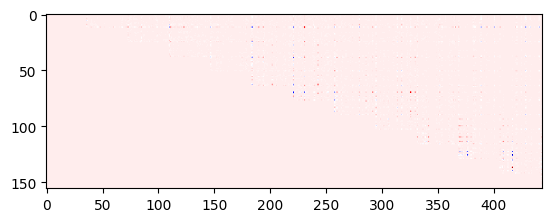

tensor(-8.5285e-07)


In [48]:
import matplotlib.pyplot as plt

plt.imshow(graph.eap_scores, cmap='seismic')
plt.show()
print(t.mean(graph.eap_scores))

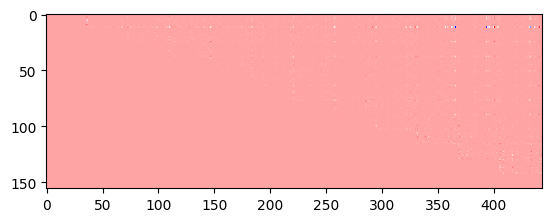

tensor(-2.4574e-06)


In [51]:
plt.imshow(graph2.eap_scores, cmap='seismic')
plt.show()
print(t.mean(graph2.eap_scores))

Seems like noising does pick up on more stuff in general, as expected.
But the places in the plot where they pick up activity do seem to be different!
Denoising seems to mostly pick up on MLP0 output edges which write to heads later in the network. This makes sense as a candidate for "sufficient" edges - they're the closest thing to embed->unembed.
Obviously these edges aren't too meaningful. But confirmation that these plots are different makes me want to go ahead with the interleaving algorithm.